                                    Property Annotation        Value
0                      Porosity in fraction:        phi     0.500000
1                    Reservoir Length in ft:          L  1000.000000
2                     Reservoir Width in ft:          W   100.000000
3                    Reservoir Height in ft:          H    10.000000
4                           Viscosity in cp:         mu     0.800000
5           Total Compressibility in psi^-1:         Ct     0.000005
6   Fluid Formation Volume Factor in rb/stb:         Bo     1.100000
7                         Time Step in days:      Del_t     0.003000
8                      Number of Time Steps:         Nt   180.000000
9                          Number of Blocks:          N    10.000000
10         Reservoir Pressure in psi at t=0:         Pi  2000.000000
11              BHP in psi at x=0 for all t:        Pwb  1000.000000


                           Property  Value
0   Permeability for Block 1 in md:     50
1   Permeabilit

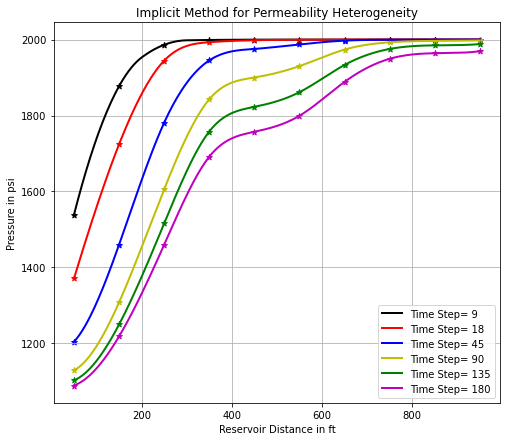

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import scipy
import pandas as pd
import statistics
from scipy.interpolate import make_interp_spline, BSpline
%matplotlib inline

#input reservoir data and permeability for any number of blocks
xls = pd.ExcelFile('Data_10Blocks.xlsx')
Reservoir_data = pd.read_excel(xls, 'Sheet1')
perm = pd.read_excel(xls, 'Sheet2')
print(Reservoir_data)
print("\n")
print(perm)
phi=np.float64(Reservoir_data['Value'][0])
L=np.float64(Reservoir_data['Value'][1])
W=np.float64(Reservoir_data['Value'][2])
H=np.float64(Reservoir_data['Value'][3])
mu=np.float64(Reservoir_data['Value'][4])
Ct=np.float64(Reservoir_data['Value'][5])
Bo=np.float64(Reservoir_data['Value'][6])
Del_t=np.float64(Reservoir_data['Value'][7])
Nt=int(Reservoir_data['Value'][8])
N=int(Reservoir_data['Value'][9])
Del_x=L/N
print("\nSize of Block: ", Del_x, "ft")
Pi=float(Reservoir_data['Value'][10]) # input Initial condition: reservoir pressure at t=0
Pwb=float(Reservoir_data['Value'][11]) # input Boundary conditions: Dirichlet condition for placement of well and Neumann condition for no flow at reservoir boundary
print("\nIC \n at t=0, Reservoir Pressure is ", Pi, " psi \nBCs \n at x=0 (DIRICHLET BC), BHP is ", Pwb, "psi \n at x=L (NEUMANN BC), NO  FLOW is there i.e., (Del_P/Del_x)=0 at x=L\n")

k=[]
for i in range(N):
    k.append(float(perm['Value'][i]))
k50=statistics.mean(k)
k84=statistics.stdev(k)
V=k84/k50  # Dykstra-Parsons Hetergeneity coefficient
print("\nEstimation of Dykstra-Parsons Heterogeneity Coefficient:\nFrom the given Permeability data, K50 = ",k50," md and K84.1 = ",k84, " md \nSo, V = (k50-k84)/k50 = ",V)
x=[]
for j in range(N):
    x.append('Block '+str(j+1))
print("\nEstimation of Each Block eta Values:")
eta=[]
for i in range(N):
    eta.append(0.00633*k[i]*Del_t/phi/mu/Ct/(Del_x**2))
data3={"Blocks":x,"eta":eta}
eachblocketa=pd.DataFrame.from_dict(data3)
print(eachblocketa)
print("\n")
print("Estimation of InterBlock k and eta Values:")
kib=[2*k[0]]
for i in range(N-1):
    kib.append(2/((1/k[i])+(1/k[i+1])))
etaib=[]
for i in range(N):
    etaib.append(0.00633*kib[i]*Del_t/phi/mu/Ct/(Del_x**2))
y=[]
for i in range(N):
    y.append('Block '+str(i)+','+str(i+1))
data4={"Blocks":y,"InterBlock k in md":kib,"InterBlock eta":etaib}
interblocketa=pd.DataFrame.from_dict(data4)
print(interblocketa)
print("\n")

# Estimation of Tri-Diagonal Matrix for Implicit formulation
etamat=np.zeros((N,N))
for i in range(N-1):
    for j in range(N):
        if j==i-1:
            etamat[i,j]=-etaib[i]
        elif j==i:
            etamat[i,j]=1+etaib[i]+etaib[i+1]
        elif j==i+1:
            etamat[i,j]=-etaib[i+1]
etamat[N-1,N-2]=-etaib[N-1]
etamat[N-1,N-1]=1+etaib[N-1]
print("Tri-diagonal Matrix or eta-matrix is estimated as: \n"+str(etamat))
tridiag=pd.DataFrame(etamat)
etainv=np.linalg.inv(etamat)
P=np.full((Nt+1,N),Pi,dtype=np.float64)
for i in range(1,Nt+1):
    B=P[i-1,:]
    F=np.zeros((N))
    F[0]=etaib[0]*Pwb
    P[i,:]=np.dot(etainv,B+F)
print("\n")
print("Note: BP is Block Pressure \n")
s=[]
m=[]
for i in range(N):
    s.append("BP"+str(i+1)+"("+str((i+0.5)*Del_x)+"ft)")
    m.append((i+0.5)*Del_x)
sk=["Time Steps", "Time(days)"]
ss=np.hstack([sk,s])
z=np.arange(0,Nt+1,dtype=int)
h=np.arange(0,Del_t*(Nt+1),Del_t,dtype=np.float64)
zh=[z,h]
hz=np.transpose(zh)
Pk=np.hstack([hz,P])
Pr=pd.DataFrame(Pk,columns=ss)

# Generating output file with eta values and pressure estimation for each blocks at any time
with pd.ExcelWriter("Output_Implicit_10Blocks.xlsx") as writer:
    eachblocketa.to_excel(writer, sheet_name="Each Block Eta", index=False)
    interblocketa.to_excel(writer, sheet_name="Inter Block k and Eta", index=False)
    tridiag.to_excel(writer, sheet_name="Tri-Diagonal Matrix", index=False)
    Pr.to_excel(writer, sheet_name="Pressure Response", index=False)
    
# Plotting pressure responses for different blocks at specific time
plt.figure(figsize=(8,7))
plt.title('Implicit Method for Permeability Heterogeneity') 
plt.scatter(m, P[math.floor(Nt/20),:], marker = '*', color = 'k')
plt.scatter(m, P[math.floor(Nt/10),:], marker = '*', color = 'r')
plt.scatter(m, P[math.floor(Nt/4),:], marker = '*', color = 'b')
plt.scatter(m, P[math.floor(Nt/2),:], marker = '*', color = 'y')
plt.scatter(m, P[math.floor(3*Nt/4),:], marker = '*', color = 'g')
plt.scatter(m, P[10*math.floor(Nt/10),:], marker = '*', color = 'm')
m_ = np.linspace(m[0], m[-1], 300) 
spl1 = make_interp_spline(m, P[math.floor(Nt/20),:], k=2)
P_1 = spl1(m_)
spl2 = make_interp_spline(m, P[math.floor(Nt/10),:], k=3)
P_2 = spl2(m_)
spl3 = make_interp_spline(m, P[math.floor(Nt/4),:], k=3)
P_3 = spl3(m_)
spl4 = make_interp_spline(m, P[math.floor(Nt/2),:], k=3)
P_4 = spl4(m_)
spl5 = make_interp_spline(m, P[math.floor(3*Nt/4),:], k=3)
P_5 = spl5(m_)
spl6 = make_interp_spline(m, P[10*math.floor(Nt/10),:], k=3)
P_6 = spl6(m_)
plt.plot(m_, P_1, color = 'k', label = 'Time Step= '+str(math.floor(Nt/20)) ,linewidth=2)
plt.plot(m_, P_2, color = 'r', label = 'Time Step= '+str(math.floor(Nt/10)) ,linewidth=2)
plt.plot(m_, P_3, color = 'b', label = 'Time Step= '+str(math.floor(Nt/4)) ,linewidth=2)
plt.plot(m_, P_4, color = 'y', label = 'Time Step= '+str(math.floor(Nt/2)) ,linewidth=2)
plt.plot(m_, P_5, color = 'g', label = 'Time Step= '+str(math.floor(3*Nt/4)) ,linewidth=2)
plt.plot(m_, P_6, color = 'm', label = 'Time Step= '+str(10*math.floor(Nt/10)) ,linewidth=2)
plt.legend()
plt.xlabel('Reservoir Distance in ft')
plt.ylabel('Pressure in psi')
plt.grid()
plt.show()
